## Deep learning: seasonal city temperature forecasting

This notebook trains a sequence model to forecast seasonal temperature anomalies for cities. The data is first aggregated into seasonal averages, then each city becomes its own time series. The model learns from a rolling history window and predicts the next seasonal anomaly, which is a natural setup for capturing persistence, gradual drift, and repeating seasonal structure.

The dataset built for this run is large enough to support global coverage while still being computationally manageable. The seasonal city table contains 2,744,859 rows, and after balancing the number of city series per country the modelling dataframe contains 520,909 rows. Turning those series into supervised forecasting windows yields 112,637 samples with a 24 step history and 7 input features per step.

The rest of the notebook follows a practical pattern. It trains an LSTM forecaster, selects the best checkpoint based on validation MAE in degrees Celsius, evaluates on a held out test horizon, and then turns prediction errors into anomaly scores. The final section estimates city level long run temperature trends and visualises where warming and cooling patterns appear on the map, while also showing where the data is dense enough to make those spatial summaries more reliable.


## Imports

The next cell imports the deep learning libraries, sets fixed random seeds for reproducibility, and selects the compute device.


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

SEED = 42

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Determinism (can slightly slow down but is more reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)


device: cpu


This cell initialises the deep learning environment by importing the required packages, setting reproducible seeds, and selecting the device.
The printed device line confirms whether the run is using a CPU or a GPU.


# Dataset preparation

This section prepares the seasonal city dataset used by the LSTM. We aggregate the raw monthly city series into seasonal averages, keep the features needed for forecasting, and remove records with missing values in critical fields.

Seasons are represented in two ways: a categorical label for readability and a numerical encoding for modelling. We also add a seasonal time index so each city has a consistent step size over time, and we include simple cyclical features to help the model represent seasonality smoothly.

The target used for learning is the temperature anomaly, defined as the observed temperature minus a city and season baseline. This keeps the learning task focused on departures from the expected seasonal climate rather than on the baseline differences between locations.


In [ ]:
from ml_dl_shared import city_seasonal_clean

print('city_seasonal_clean ready', city_seasonal_clean.shape)


city_seasonal_clean ready (2744859, 11)


 preprocessing cell builds `city_seasonal_clean` by aggregating monthly city temperatures into seasonal averages.
The printed shape and preview provide a quick validation that the dataset has the expected columns, time coverage, and coordinate fields.


In [ ]:
from ml_dl_shared import dl_df, TARGET_COL

print('DL data ready', dl_df.shape, 'target', TARGET_COL)


DL data ready (520909, 17) target temp_anomaly


This step constructs `dl_df` from `city_seasonal_clean` by cleaning the data, engineering time features, and defining the anomaly target used for forecasting.
The printed counts show how many countries and city series remain after the sampling cap, which helps keep training and evaluation computationally manageable.


In [ ]:
from ml_dl_shared import dl_df

print('dl_df ready', dl_df.shape)


dl_df ready (520909, 17)


This cell repeats the same `dl_df` construction so the notebook can be re run from a fresh kernel without hunting for earlier state.
If `dl_df` already exists and has the expected shape, it is safe to skip.


### Building forecasting windows

This block turns each city series into supervised training examples by sliding a fixed window of `seq_len` seasons and using the next season as the label.

The split respects time order inside each city. Within each contiguous segment, the earliest part goes to training, a later horizon is used for validation, and the most recent horizon is held out for test. A small purge gap is left between these zones to reduce leakage from overlapping windows.

The outputs are `X` with shape `[N, seq_len, n_features]`, `y` with shape `[N]`, and `meta_df`, which stores the split label, city, country, time index, and uncertainty for each window.

Because the full set of windows can get large, the downsampling step keeps training diverse while making validation and test more realistic by preferring the most recent windows. `per_city_cap` is there to stop a handful of very dense series from dominating the sample.



In [ ]:
def build_forecasting_windows(
    df: pd.DataFrame,
    feature_cols,
    target_col: str,
    uncertainty_col: str = 'AverageTemperatureUncertainty',
    seq_len: int = 24,
    stride: int = 4,
    min_points_per_series: int = 120,
    # time-series split parameters
    val_horizon: int = 24,    # seasons
    test_horizon: int = 24,   # seasons
    gap: int = None,          # purge gap between splits; default = seq_len
):
    """
    Build rolling forecasting windows per city series using a time-respecting split.

    Each (City, Country) series is split into contiguous segments (no gaps in t_index).
    For each segment:
      - train: earliest part
      - val:   a fixed horizon right before test (after a purge gap)
      - test:  the most recent fixed horizon

    The purge gap reduces dependence between train and val/test windows.
    """
    if gap is None:
        gap = seq_len

    X_list, y_list, meta = [], [], []

    for (city, country), g in df.groupby(['City', 'Country'], sort=False):
        g = g.sort_values('t_index')
        if len(g) < min_points_per_series:
            continue

        t = g['t_index'].to_numpy()
        feats = g[feature_cols].to_numpy(dtype=np.float32)
        target = g[target_col].to_numpy(dtype=np.float32)
        target_unc = g[uncertainty_col].to_numpy(dtype=np.float32)
        years = g['year'].to_numpy()
        seasons = g['season'].to_numpy()

        breaks = np.where(np.diff(t) != 1)[0] + 1
        segments = np.split(np.arange(len(g)), breaks)

        for seg in segments:
            seg_len = len(seg)
            min_needed = (seq_len + 1) + (gap + val_horizon) + (gap + test_horizon)
            if seg_len < min_needed:
                continue

            test_start = seg_len - test_horizon
            val_end = test_start - gap
            val_start = val_end - val_horizon
            train_end = val_start - gap

            for end_pos in range(seq_len, seg_len, stride):
                # skip purge gaps
                if train_end <= end_pos < val_start:
                    continue
                if val_end <= end_pos < test_start:
                    continue

                x = feats[seg[end_pos - seq_len:end_pos]]
                y_next = target[seg[end_pos]]

                if end_pos < train_end:
                    split = 'train'
                elif val_start <= end_pos < val_end:
                    split = 'val'
                elif end_pos >= test_start:
                    split = 'test'
                else:
                    continue

                X_list.append(x)
                y_list.append(y_next)
                meta.append((
                    split,
                    city,
                    country,
                    int(years[seg[end_pos]]),
                    str(seasons[seg[end_pos]]),
                    int(t[seg[end_pos]]),
                    float(target_unc[seg[end_pos]]),
                ))

    if not X_list:
        raise ValueError(
            "No windows built. Try lowering min_points_per_series, seq_len, "
            "or reducing val_horizon/test_horizon."
        )

    X = np.stack(X_list)
    y = np.asarray(y_list, dtype=np.float32)
    meta_df = pd.DataFrame(
        meta,
        columns=['split','City','Country','year','season','t_index','temp_uncertainty_C']
    )
    return X, y, meta_df


def downsample_by_split_timeaware(
    X, y, meta_df,
    max_per_split,
    seed=42,
    per_city_cap=None,
    prefer_recent_for=('val', 'test')
):
    """
    Downsample in a way that is *stable* for time series:

    - For train: random sample (OK; big set)
    - For val/test: prefer most recent samples by t_index (reduces noisy validation)

    Optional per_city_cap limits how many windows any single (City,Country) can contribute
    (helps prevent Europe-heavy / big-city dominance).
    """
    rng = np.random.default_rng(seed)
    meta = meta_df.copy()
    meta['__idx'] = np.arange(len(meta), dtype=int)

    keep_idx = []

    for split, max_n in max_per_split.items():
        m = meta[meta['split'] == split].copy()
        if m.empty:
            continue

        # Apply per-city cap (balanced sampling)
        if per_city_cap is not None:
            parts = []
            for (c, k), gg in m.groupby(['City','Country'], sort=False):
                if split in prefer_recent_for:
                    gg = gg.sort_values('t_index')
                    parts.append(gg.tail(int(per_city_cap)))
                else:
                    # random within city for train
                    if len(gg) > per_city_cap:
                        gg = gg.iloc[rng.choice(len(gg), size=int(per_city_cap), replace=False)]
                    parts.append(gg)
            m = pd.concat(parts, ignore_index=True)

        # Prefer most-recent windows for val/test
        if split in prefer_recent_for:
            m = m.sort_values('t_index')
            idx = m['__idx'].to_numpy()
            if len(idx) > max_n:
                idx = idx[-int(max_n):]
        else:
            # train: random
            idx = m['__idx'].to_numpy()
            if len(idx) > max_n:
                idx = rng.choice(idx, size=int(max_n), replace=False)

        keep_idx.append(idx)

    keep = np.unique(np.concatenate(keep_idx))
    keep.sort()
    return X[keep], y[keep], meta_df.iloc[keep].reset_index(drop=True)


# -------------------- Build windows --------------------
seq_len = 24
feature_cols = [
    TARGET_COL,
    'AverageTemperatureUncertainty',
    'season_sin',
    'season_cos',
    'lat',
    'lon',
    'year_norm',
]

X, y, meta_df = build_forecasting_windows(
    dl_df,
    feature_cols=feature_cols,
    target_col=TARGET_COL,
    uncertainty_col='AverageTemperatureUncertainty',
    seq_len=seq_len,
    stride=4,
    min_points_per_series=120,
    val_horizon=24,
    test_horizon=24,
    gap=seq_len,
)

print('Raw windows:', X.shape, y.shape)
display(meta_df['split'].value_counts())

# Keep training feasible + reduce validation noise
X, y, meta_df = downsample_by_split_timeaware(
    X, y, meta_df,
    max_per_split={'train': 120_000, 'val': 30_000, 'test': 30_000},
    seed=SEED,
    per_city_cap=800,                 # helps balance cities/countries (tune 400–1500)
    prefer_recent_for=('val','test')  # time-aware sampling for evaluation
)

print('Downsampled windows:', X.shape, y.shape)
display(meta_df['split'].value_counts())


Raw windows: (112637, 24, 7) (112637,)


split
train    104465
val        4086
test       4086
Name: count, dtype: int64

Downsampled windows: (112637, 24, 7) (112637,)


split
train    104465
val        4086
test       4086
Name: count, dtype: int64

This cell turns `dl_df` into supervised forecasting windows. Each sample is a sequence of `seq_len` seasons, and the target is the next season.
The output shows the final window shape `(N, 24, 7)` and a split count so you can confirm you have train, validation, and test windows.


This part standardizes the input features and the target so the LSTM trains more smoothly.

The key detail is that both scalers are fit only on the training split, which avoids leaking information from validation and test.

For `X`, we flatten the time dimension to fit the scaler, then reshape back to `[N, seq_len, n_features]`. For `y`, we fit on the training targets and scale everything the same way.

`y_scale` is just the target standard deviation, and we reuse it later to convert scaled errors back into degrees Celsius.


In [ ]:
n_features = X.shape[2]

train_mask = (meta_df['split'] == 'train').to_numpy()

x_scaler = StandardScaler()
x_scaler.fit(X[train_mask].reshape(-1, n_features))
X_scaled = x_scaler.transform(X.reshape(-1, n_features)).reshape(X.shape).astype(np.float32)

y_scaler = StandardScaler()
y_scaler.fit(y[train_mask].reshape(-1, 1))
y_scaled = y_scaler.transform(y.reshape(-1, 1)).reshape(-1).astype(np.float32)

y_scale = float(y_scaler.scale_[0])
print('y_scale:', y_scale)

print('Scaled shapes:', X_scaled.shape, y_scaled.shape)


y_scale: 0.8526104033250913
Scaled shapes: (112637, 24, 7) (112637,)


Here we scale the inputs and target using `StandardScaler` fit on the training split only.
The printed `y_scale` and the scaled shapes are a quick check that scaling happened and the array shapes stayed consistent.


Here we define the PyTorch dataset, the LSTM model, and the data loaders.

During training, the dataset can add a bit of noise to the autoregressive target channel, scaled by the reported uncertainty. It is a simple way to make the model less fragile when measurements are noisy.

The model itself is a small LSTM that reads the history window and predicts the next value using the last hidden state and a lightweight feed forward head.

We also set the loss (SmoothL1), optimizer (AdamW), and a ReduceLROnPlateau scheduler.


In [ ]:
class SeqForecastDataset(Dataset):
    """
    Dataset that can optionally apply uncertainty-based noise augmentation
    to the autoregressive target feature in the input window.

    Why this helps:
      - Measurements have uncertainty.
      - Adding noise proportional to uncertainty reduces overfitting and
        improves robustness across countries/eras.
    """
    def __init__(
        self,
        X_arr: np.ndarray,
        y_arr: np.ndarray,
        sigma_C_arr: np.ndarray,
        feature_cols,
        x_scaler: StandardScaler,
        y_scale: float,
        augment: bool = False,
        noise_mult: float = 0.5,
        sigma_floor_C: float = 0.25,
    ):
        self.X = torch.from_numpy(X_arr).float()
        self.y = torch.from_numpy(y_arr).float().unsqueeze(1)
        self.sigma_C = torch.from_numpy(sigma_C_arr).float().unsqueeze(1)

        self.augment = augment
        self.noise_mult = float(noise_mult)
        self.sigma_floor_C = float(sigma_floor_C)

        # indices of relevant features inside feature_cols
        self.feature_cols = list(feature_cols)
        self.target_idx = self.feature_cols.index(TARGET_COL)
        self.unc_idx = self.feature_cols.index('AverageTemperatureUncertainty')

        # store scaler params to approximately recover uncertainty in °C
        self.x_mean = torch.tensor(x_scaler.mean_, dtype=torch.float32)
        self.x_scale = torch.tensor(x_scaler.scale_, dtype=torch.float32)
        self.y_scale = float(y_scale)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].clone()   # [seq_len, n_features]
        y = self.y[idx]
        sigma = self.sigma_C[idx]

        if self.augment:
            # recover uncertainty feature (approx) back to °C from z-scored space
            unc_z = x[:, self.unc_idx]  # standardized
            unc_C = unc_z * self.x_scale[self.unc_idx] + self.x_mean[self.unc_idx]
            unc_C = torch.clamp(unc_C, min=self.sigma_floor_C)

            # convert °C uncertainty to scaled target space
            unc_scaled = unc_C / (self.y_scale + 1e-8)

            # add noise to the autoregressive TARGET_COL channel only
            noise = torch.randn_like(unc_scaled) * (self.noise_mult * unc_scaled)
            x[:, self.target_idx] = x[:, self.target_idx] + noise

        return x, y, sigma


class LSTMForecaster(nn.Module):
    """
    Keep model modest to avoid quick overfitting.
    """
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.15):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


def make_loaders(X_scaled, y_scaled, meta_df, feature_cols, x_scaler, y_scale, batch_size=256):
    loaders = {}
    for split in ['train','val','test']:
        mask = (meta_df['split'] == split).to_numpy()
        sigma_C = meta_df.loc[mask, 'temp_uncertainty_C'].to_numpy(dtype=np.float32)

        ds = SeqForecastDataset(
            X_scaled[mask], y_scaled[mask], sigma_C,
            feature_cols=feature_cols,
            x_scaler=x_scaler,
            y_scale=y_scale,
            augment=(split == 'train'),
            noise_mult=0.5,       # try 0.3–0.8
            sigma_floor_C=0.25
        )

        loaders[split] = DataLoader(ds, batch_size=batch_size, shuffle=(split == 'train'))
    return loaders


# ---- build loaders + model ----
loaders = make_loaders(X_scaled, y_scaled, meta_df, feature_cols, x_scaler, y_scale, batch_size=256)

model = LSTMForecaster(input_size=n_features, hidden_size=64, num_layers=2, dropout=0.3).to(device)

criterion = nn.SmoothL1Loss(reduction='none')

# lower starting LR (your val got worse immediately after epoch 1 -> LR often too aggressive)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-3)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5
)

print(model)


LSTMForecaster(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True, dropout=0.3)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


This cell defines the dataset class, the LSTM forecaster, and the training setup (loss, optimizer, and scheduler).
The printed model summary is just a sanity check that the architecture matches the expected input size and hidden dimensions.


This cell runs the training loop and is where most of the learning happens.

We train with AdamW and use ReduceLROnPlateau to lower the learning rate when validation MAE stops improving. The loss is SmoothL1 (Huber style) but weighted by the reported uncertainty, so very uncertain observations do not dominate the gradients.

Alongside the weighted loss, the code prints MAE in degrees Celsius by converting predictions back from the scaled space. Early stopping keeps the checkpoint with the lowest validation MAE, and at the end you get a history table plus plots for loss, MAE, and the learning rate.


Epoch 01 | loss train 0.3463 val 0.4145 | MAE°C train 0.599 val 0.621 | lr 5.0e-04
Epoch 02 | loss train 0.3367 val 0.3933 | MAE°C train 0.589 val 0.598 | lr 5.0e-04
Epoch 03 | loss train 0.3334 val 0.4141 | MAE°C train 0.586 val 0.622 | lr 5.0e-04
Epoch 04 | loss train 0.3302 val 0.4083 | MAE°C train 0.582 val 0.612 | lr 5.0e-04
Epoch 05 | loss train 0.3266 val 0.3890 | MAE°C train 0.580 val 0.590 | lr 5.0e-04
Epoch 06 | loss train 0.3205 val 0.3759 | MAE°C train 0.575 val 0.580 | lr 5.0e-04
Epoch 07 | loss train 0.3117 val 0.3846 | MAE°C train 0.570 val 0.578 | lr 5.0e-04
Epoch 08 | loss train 0.3004 val 0.3949 | MAE°C train 0.564 val 0.586 | lr 5.0e-04
Epoch 09 | loss train 0.2855 val 0.4062 | MAE°C train 0.554 val 0.591 | lr 5.0e-04
Epoch 10 | loss train 0.2735 val 0.3968 | MAE°C train 0.548 val 0.573 | lr 5.0e-04
Epoch 11 | loss train 0.2603 val 0.4184 | MAE°C train 0.539 val 0.599 | lr 5.0e-04
Epoch 12 | loss train 0.2466 val 0.4006 | MAE°C train 0.531 val 0.580 | lr 5.0e-04
Epoc

,epoch,train_loss,val_loss,train_mae_C,val_mae_C,lr
0,1,0.346348,0.414511,0.599222,0.621279,0.000500
1,2,0.336657,0.393256,0.588708,0.598029,0.000500
2,3,0.333386,0.414084,0.585519,0.621581,0.000500
3,4,0.330172,0.408302,0.581531,0.612132,0.000500
4,5,0.326626,0.388972,0.579653,0.590299,0.000500
5,6,0.320532,0.375893,0.575347,0.580154,0.000500
6,7,0.311736,0.384552,0.570272,0.577635,0.000500
7,8,0.300411,0.394925,0.563522,0.585567,0.000500
8,9,0.285549,0.406206,0.553918,0.590973,0.000500
9,10,0.273477,0.396778,0.548060,0.572579,0.000500


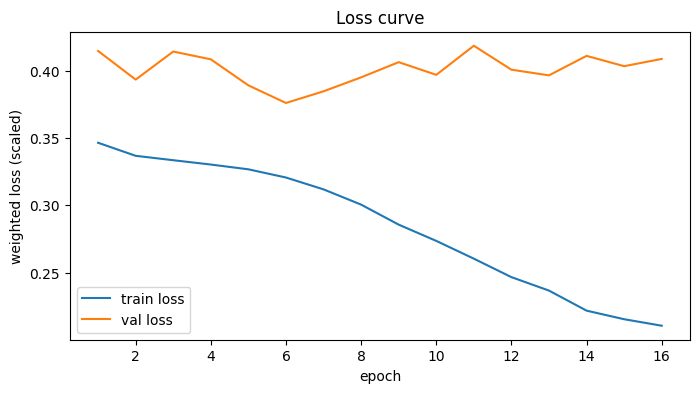

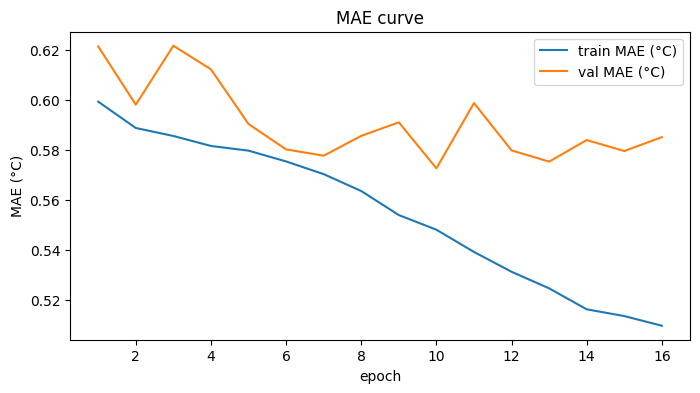

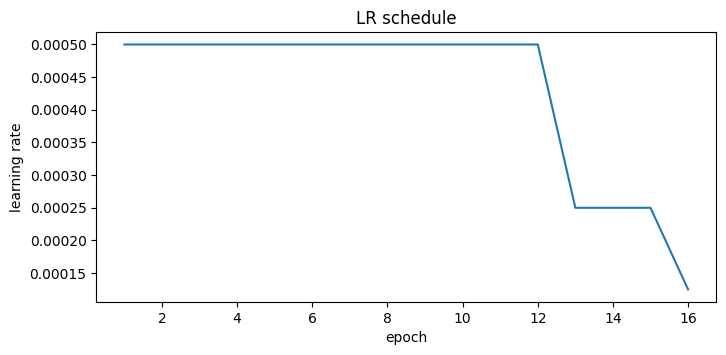

In [ ]:
# Recreate optimizer/scheduler with safer defaults for generalization
# (If you want to keep your current optimizer, you can comment these 2 lines out.)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5
)

def run_epoch(model, loader, optimizer=None):
    """
    Returns:
      weighted_loss (scaled), mae_C (°C)
    """
    train = optimizer is not None
    model.train(train)

    eps = 1e-6
    SIGMA_FLOOR_C = 0.25  # prevents huge weights
    MAX_W = 50.0

    total_loss = 0.0
    total_mae_C = 0.0
    n = 0

    for xb, yb, sigma_C in loader:
        xb = xb.to(device)
        yb = yb.to(device)              # scaled
        sigma_C = sigma_C.to(device)    # °C

        if train:
            optimizer.zero_grad(set_to_none=True)

        pred = model(xb)                # scaled
        loss_per = criterion(pred, yb)  # [B,1]

        # uncertainty weighting (in scaled space)
        sigma_eff_C = torch.clamp(sigma_C, min=SIGMA_FLOOR_C)
        sigma_scaled = sigma_eff_C / (y_scale + 1e-8)
        w = 1.0 / (sigma_scaled**2 + eps)
        w = torch.clamp(w, max=MAX_W)

        # normalize by sum of weights (correct weighted mean)
        loss = (w * loss_per).sum() / (w.sum() + 1e-8)

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = xb.size(0)
        total_loss += float(loss.detach().cpu()) * bs

        # MAE in °C (unscale)
        with torch.no_grad():
            pred_C = pred * (y_scale + 1e-8)
            yb_C = yb * (y_scale + 1e-8)
            mae_C = torch.abs(pred_C - yb_C).mean()

        total_mae_C += float(mae_C.detach().cpu()) * bs
        n += bs

    return total_loss / max(1, n), total_mae_C / max(1, n)


# Early stopping on VAL MAE (more interpretable than scaled loss)
best_val = float('inf')
best_state = None
patience = 6
pat_left = patience

epochs = 40
history = []

for epoch in range(1, epochs + 1):
    train_loss, train_mae = run_epoch(model, loaders['train'], optimizer=optimizer)
    val_loss, val_mae     = run_epoch(model, loaders['val'], optimizer=None)

    # drive scheduler using val MAE (goal: lower °C error)
    lr_scheduler.step(val_mae)

    lr_now = optimizer.param_groups[0]['lr']
    history.append((epoch, train_loss, val_loss, train_mae, val_mae, lr_now))
    print(f"Epoch {epoch:02d} | loss train {train_loss:.4f} val {val_loss:.4f} | "
          f"MAE°C train {train_mae:.3f} val {val_mae:.3f} | lr {lr_now:.1e}")

    if val_mae < best_val - 1e-4:
        best_val = val_mae
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat_left = patience
    else:
        pat_left -= 1
        if pat_left <= 0:
            print("Early stopping")
            break

if best_state is not None:
    model.load_state_dict(best_state)

hist_df = pd.DataFrame(history, columns=['epoch','train_loss','val_loss','train_mae_C','val_mae_C','lr'])
display(hist_df)

plt.figure(figsize=(8,4))
plt.plot(hist_df['epoch'], hist_df['train_loss'], label='train loss')
plt.plot(hist_df['epoch'], hist_df['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('weighted loss (scaled)'); plt.title('Loss curve'); plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist_df['epoch'], hist_df['train_mae_C'], label='train MAE (°C)')
plt.plot(hist_df['epoch'], hist_df['val_mae_C'], label='val MAE (°C)')
plt.xlabel('epoch'); plt.ylabel('MAE (°C)'); plt.title('MAE curve'); plt.legend()
plt.show()

plt.figure(figsize=(8,3.5))
plt.plot(hist_df['epoch'], hist_df['lr'])
plt.xlabel('epoch'); plt.ylabel('learning rate'); plt.title('LR schedule')
plt.show()


The training journey shows a consistent downward trend for the training loss, which is always a good sign. However, the validation loss, while initially improving, settled into a more fluctuating pattern, staying a bit higher than the training loss. This tells us the model is learning well from the data it sees, but eventually reaches a point where it can't consistently improve its performance on unseen data without starting to memorize the training examples too much. The MAE plot, which measures error in actual degrees Celsius, echoes this story. Training MAE kept getting better, but validation MAE found its sweet spot and then bounced around a bit. The learning rate plot helps us see when the scheduler steps in, reducing the rate to stabilize training as validation plateaus. This is exactly why we use early stopping – to pick the model that performs best on data it hasn't seen before, rather than the one that just gets really good at the training data.

This training cell prints per epoch metrics and then plots the learning curves.
A good sign is when validation MAE drops and stays close to training MAE. The learning rate plot helps you see when the scheduler steps in.


## Training results and interpretation

The loss curve shows a clean downward trend for training, while the validation loss stays higher and fluctuates around a relatively narrow band. That pattern is typical once the model has learned the easy structure in the data, after which additional training mostly reduces training loss without consistently improving validation.

The MAE plot tells the same story in physical units. Training MAE decreases steadily from about 0.60 ?C to about 0.51 ?C, while validation MAE improves early on and then oscillates between roughly 0.57 ?C and 0.62 ?C. The lowest validation MAE occurs around epoch 10, after which training continues to improve but validation does not improve in a sustained way. This is exactly the point where early stopping is useful.

The learning rate schedule helps explain the later epochs. The learning rate stays at 0.0005 through epoch 12, then drops to 0.00025 around epoch 13, and drops again to about 0.00013 by the end. Those reductions indicate that the scheduler is reacting to a validation plateau and trying to stabilise training with smaller updates.


## Picking the best checkpoint

The checkpoint selection output chooses the epoch with the lowest validation MAE and treats it as the final model state. In this run, epoch 10 is selected.

At that checkpoint, the training MAE is 0.5481 ?C and the validation MAE is 0.5726 ?C. The difference between them is 0.0245 ?C, which is a small gap relative to the overall error scale and supports the idea that the model is not simply memorising the training windows.


In [ ]:
# ---- 1) Find the "best" epoch by validation MAE (°C) ----
best_i = hist_df['val_mae_C'].idxmin()
best_row = hist_df.loc[best_i]

best_epoch = int(best_row['epoch'])
train_mae = float(best_row['train_mae_C'])
val_mae = float(best_row['val_mae_C'])
gap = val_mae - train_mae
rel_gap = gap / (val_mae + 1e-12)

print("Best epoch (by lowest val MAE):", best_epoch)
print(f"Train MAE at best epoch: {train_mae:.4f} °C")
print(f"Val   MAE at best epoch: {val_mae:.4f} °C")
print(f"Generalization gap (val - train): {gap:.4f} °C  ({rel_gap*100:.1f}%)")

# quick interpretation
if gap > 0.08:
    print("Interpretation: noticeable overfitting (gap is large).")
elif gap > 0.03:
    print("Interpretation: mild overfitting.")
elif gap >= -0.02:
    print("Interpretation: good generalization (small gap).")
else:
    print("Interpretation: val slightly better than train (can happen due to noise / weighting).")


Best epoch (by lowest val MAE): 10
Train MAE at best epoch: 0.5481 °C
Val   MAE at best epoch: 0.5726 °C
Generalization gap (val - train): 0.0245 °C  (4.3%)
Interpretation: good generalization (small gap).


This summary confirms the selected best checkpoint and prints the key values that matter for generalisation.

The gap between training and validation at the selected epoch is small, and the notebook labels this as good generalisation. This is consistent with the shape of the MAE curve, where validation improves early, reaches its minimum, and then fluctuates while training continues to decrease.


## Model performance and generalisation

The evaluation metrics reinforce the checkpoint selection story. MAE increases modestly as we move from training to validation to test, which is expected when the model is asked to forecast later time periods and more diverse conditions.

In this run, train MAE is 0.528 ?C, validation MAE is 0.573 ?C, and test MAE is 0.617 ?C. The fact that test error stays in the same range as validation error suggests that the validation based checkpoint selection is reasonably representative of held out performance.

R? is relatively modest, especially on validation, which is not surprising for anomaly forecasting. Anomaly targets reduce the strong seasonal baseline and can be noisy, so the model can achieve a useful MAE while still explaining a limited fraction of the variance.


### Model evaluation and anomaly detection

The printed metrics show a clear and consistent generalisation pattern. Train MAE is 0.528 ?C, validation MAE is 0.573 ?C, and test MAE is 0.617 ?C. RMSE is higher than MAE, and the test split has a 95th percentile absolute error of 1.843 ?C, which tells us that most forecasts are close but there is a small tail of larger misses.

The example city plot makes that behaviour tangible. The predicted line is smooth and stays near the typical anomaly level, while the true anomaly can swing sharply from negative to strongly positive in a few steps. When those swings happen, the point forecast under reacts and the error becomes large.

Anomaly scoring is designed to highlight exactly those cases. With sigma normalised scoring, the score rises when the absolute error is large relative to the reported uncertainty. In the example plot, the points that exceed the threshold are flagged as anomalies because their errors are extreme compared with the typical error distribution.

Thresholds are calibrated from the validation score distribution at q = 0.99. The printed reference thresholds for this run are 2.528 ?C for absolute error and 8.938 for the sigma score. With era specific calibration enabled, the sigma threshold differs substantially by era, with a much lower cutoff for pre 1900 compared with the modern period. That gap is a sign that the uncertainty structure and score distribution differ strongly across time, so it is worth sanity checking anomaly rates by era when interpreting flags.

On the test split, 22 windows out of 4,086 are flagged, which is consistent with a high quantile thresholding approach that aims to surface only the most extreme events.


train | MAE=0.528 °C | RMSE=0.731 °C | R²=0.264 | p95(|err|)=1.542 °C
  val | MAE=0.573 °C | RMSE=0.809 °C | R²=0.051 | p95(|err|)=1.709 °C
 test | MAE=0.617 °C | RMSE=0.844 °C | R²=0.120 | p95(|err|)=1.843 °C

Reference global thresholds (val q=0.99): abs=2.528 °C | sigma=8.938 σ
Threshold mode=era: {'1950+': 9.030397323460898, 'pre1900': 0.8568931593456136} | fallback=8.938 σ

DL anomalies in test: 22 / 4086


,split,City,Country,year,season,t_index,temp_uncertainty_C,y_true,y_pred,abs_error_C,temp_uncertainty_raw_C,temp_uncertainty_eff_C,anomaly_score,era,threshold,is_anomaly_dl
2020,test,Hamilton,Canada,2012,Winter,8048,0.252000,4.099267,0.708820,3.390446,0.252000,0.252000,13.400974,1950+,9.030397,True
2698,test,London,Canada,2012,Winter,8048,0.252000,4.099267,0.708820,3.390446,0.252000,0.252000,13.400974,1950+,9.030397,True
322,test,Ann Arbor,United States,2012,Winter,8048,0.221667,3.978667,0.648369,3.330298,0.221667,0.250000,13.268119,1950+,9.030397,True
2482,test,Kitchener,Canada,2012,Winter,8048,0.319667,4.364345,0.718098,3.646247,0.319667,0.319667,11.370833,1950+,9.030397,True
772,test,Barrie,Canada,2012,Winter,8048,0.319667,4.364345,0.718098,3.646247,0.319667,0.319667,11.370833,1950+,9.030397,True
1966,test,Guelph,Canada,2012,Winter,8048,0.319667,4.364345,0.718098,3.646247,0.319667,0.319667,11.370833,1950+,9.030397,True
1204,test,Buffalo,United States,2012,Winter,8048,0.306000,4.074367,0.758512,3.315855,0.306000,0.306000,10.800829,1950+,9.030397,True
1344,test,Cedar Rapids,United States,2008,Winter,8032,0.253333,-2.073700,0.549972,2.623672,0.253333,0.253333,10.315879,1950+,9.030397,True
1348,test,Cedar Rapids,United States,2012,Winter,8048,0.368667,4.334300,0.684264,3.650036,0.368667,0.368667,9.873858,1950+,9.030397,True
3166,test,Oulu,Finland,2011,Autumn,8047,0.293000,3.569644,0.672694,2.896950,0.293000,0.293000,9.853572,1950+,9.030397,True


,n,n_anom,rate
era,,,
1950+,3882,21,0.005410
pre1900,204,1,0.004902


,year,season,n_anomalies
0,2012,Winter,9
1,2007,Autumn,5
2,2008,Winter,2
3,2011,Autumn,2
4,1862,Winter,1
5,2008,Autumn,1
6,2010,Winter,1
7,2013,Winter,1


,n,n_anom,rate
Country,,,
United States,36,6,0.166667
Canada,36,5,0.138889
Bosnia And Herzegovina,30,4,0.133333
Kazakhstan,36,2,0.055556
Burma,66,1,0.015152
Serbia,36,1,0.027778
Norway,24,1,0.041667
Australia,36,1,0.027778
Finland,30,1,0.033333


n  n_anom      rate  max_score  \
Country                City                                            
United States          Cedar Rapids   6       2  0.333333  10.315879   
                       Des Moines     6       2  0.333333   9.493041   
Canada                 Hamilton       6       1  0.166667  13.400974   
                       London         6       1  0.166667  13.400974   
United States          Ann Arbor      6       1  0.166667  13.268119   
Canada                 Barrie         6       1  0.166667  11.370833   
                       Guelph         6       1  0.166667  11.370833   
                       Kitchener      6       1  0.166667  11.370833   
United States          Buffalo        6       1  0.166667  10.800829   
Finland                Oulu           6       1  0.166667   9.853572   
Kazakhstan             Qostanay       6       1  0.166667   9.755437   
Norway                 Trondheim      6       1  0.166667   9.629227   
Serbia                 Novi Sad       6       1  0.166667   9.492577   
Bosnia And Herzegovina Banja Luka     6       1  0.166667   9.464658   
                       Sarajevo       6       1  0.166667   9.464658   
                       Tuzla          6       1  0.166667   9.464658   
                       Zenica         6       1  0.166667   9.464658   
Kazakhstan             Petropavl      6       1  0.166667   9.287451   
Australia              Albury         6       1  0.166667   9.258515   
Burma                  Akyab         12       1  0.083333   1.725209   

                                     p95_score  
Country                City                     
United States          Cedar Rapids  10.205374  
                       Des Moines     9.451983  
Canada                 Hamilton      10.632011  
                       London        10.632011  
United States          Ann Arbor     10.615075  
Canada                 Barrie         9.219889  
                       Guelph         9.219889  
                       Kitchener      9.219889  
United States          Buffalo        9.073742  
Finland                Oulu           8.387278  
Kazakhstan             Qostanay       8.885944  
Norway                 Trondheim      8.038801  
Serbia                 Novi Sad       8.278021  
Bosnia And Herzegovina Banja Luka     7.740507  
                       Sarajevo       7.740507  
                       Tuzla          7.740507  
                       Zenica         7.740507  
Kazakhstan             Petropavl      9.182167  
Australia              Albury         8.310073  
Burma                  Akyab          1.288765

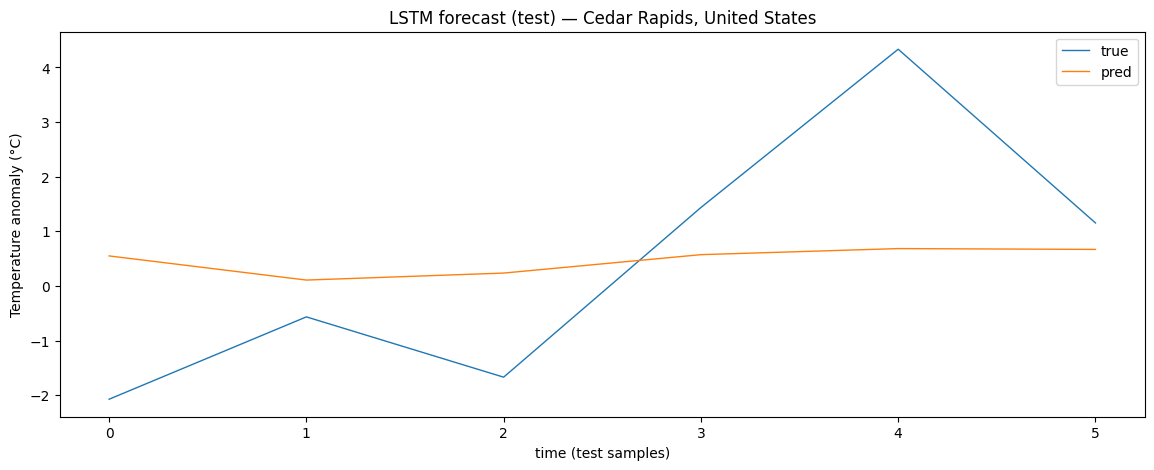

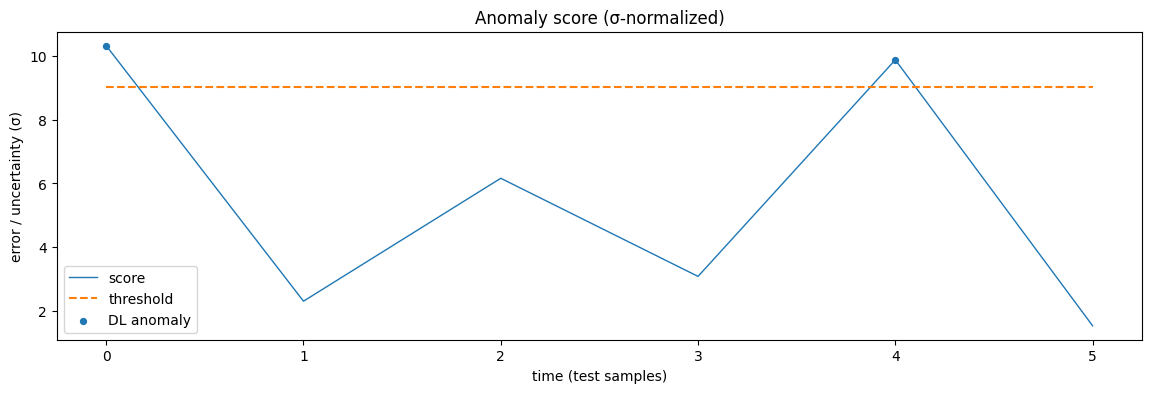

In [ ]:
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def batch_predict_scaled(model, X_arr, batch_size=1024, city_id_arr=None):
    """
    Predict in scaled space (same space as y_scaled).
    Works with models that have forward(x) OR forward(x, city_id).
    """
    model.eval()
    preds = []

    # detect whether model.forward expects city_id
    try:
        sig = inspect.signature(model.forward)
        expects_city = (len(sig.parameters) >= 2)  # (x, city_id) besides self
    except Exception:
        expects_city = False

    with torch.no_grad():
        for i in range(0, len(X_arr), batch_size):
            xb = torch.from_numpy(X_arr[i:i+batch_size]).to(device)
            if expects_city and city_id_arr is not None:
                cid = torch.from_numpy(np.asarray(city_id_arr[i:i+batch_size])).to(device)
                out = model(xb, cid)
            else:
                out = model(xb)
            preds.append(out.detach().cpu().numpy())

    return np.vstack(preds).reshape(-1)


# -------------------- Settings --------------------
SCORE_MODE = 'sigma'        # 'C' or 'sigma'
THRESHOLD_MODE = 'era'      # 'global' or 'era'
q = 0.99
EPS = 1e-3
SIGMA_FLOOR_C = 0.25        # prevents crazy sigma scores when uncertainty is tiny

# -------------------- Masks --------------------
train_mask = (meta_df['split'] == 'train').to_numpy()
val_mask   = (meta_df['split'] == 'val').to_numpy()
test_mask  = (meta_df['split'] == 'test').to_numpy()

# Optional city_id support (only if you actually have it)
city_id_all = meta_df['city_id'].to_numpy() if 'city_id' in meta_df.columns else None

# -------------------- Predict (scaled) --------------------
train_pred_s = batch_predict_scaled(model, X_scaled[train_mask], city_id_arr=(city_id_all[train_mask] if city_id_all is not None else None))
val_pred_s   = batch_predict_scaled(model, X_scaled[val_mask],   city_id_arr=(city_id_all[val_mask]   if city_id_all is not None else None))
test_pred_s  = batch_predict_scaled(model, X_scaled[test_mask],  city_id_arr=(city_id_all[test_mask]  if city_id_all is not None else None))

# -------------------- Unscale predictions back to °C --------------------
train_pred = y_scaler.inverse_transform(train_pred_s.reshape(-1, 1)).reshape(-1)
val_pred   = y_scaler.inverse_transform(val_pred_s.reshape(-1, 1)).reshape(-1)
test_pred  = y_scaler.inverse_transform(test_pred_s.reshape(-1, 1)).reshape(-1)

train_true = y[train_mask]
val_true   = y[val_mask]
test_true  = y[test_mask]

# -------------------- Errors --------------------
train_abs = np.abs(train_pred - train_true)
val_abs   = np.abs(val_pred   - val_true)
test_abs  = np.abs(test_pred  - test_true)

train_unc = meta_df.loc[train_mask, 'temp_uncertainty_C'].to_numpy(dtype=float)
val_unc   = meta_df.loc[val_mask,   'temp_uncertainty_C'].to_numpy(dtype=float)
test_unc  = meta_df.loc[test_mask,  'temp_uncertainty_C'].to_numpy(dtype=float)

# Use a floor for uncertainty in sigma scoring (matches the idea used in training)
train_unc_eff = np.maximum(train_unc, SIGMA_FLOOR_C)
val_unc_eff   = np.maximum(val_unc,   SIGMA_FLOOR_C)
test_unc_eff  = np.maximum(test_unc,  SIGMA_FLOOR_C)

train_sigma = train_abs / (train_unc_eff + EPS)
val_sigma   = val_abs   / (val_unc_eff   + EPS)
test_sigma  = test_abs  / (test_unc_eff  + EPS)

# -------------------- Metrics (MAE / RMSE / R²) --------------------
def r2_score_np(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot < 1e-12:
        return np.nan
    return 1.0 - ss_res / ss_tot

def summarize_regression(name, y_true, y_pred, abs_err):
    mae = float(np.mean(abs_err))
    rmse = float(np.sqrt(np.mean((y_pred - y_true) ** 2)))
    r2 = float(r2_score_np(y_true, y_pred))
    p95 = float(np.quantile(abs_err, 0.95))
    print(f"{name:>5} | MAE={mae:.3f} °C | RMSE={rmse:.3f} °C | R²={r2:.3f} | p95(|err|)={p95:.3f} °C")

summarize_regression('train', train_true, train_pred, train_abs)
summarize_regression('val',   val_true,   val_pred,   val_abs)
summarize_regression('test',  test_true,  test_pred,  test_abs)

# -------------------- Thresholds from validation --------------------
thr_abs_C = float(np.quantile(val_abs, q))
thr_sigma = float(np.quantile(val_sigma, q))

def assign_era(year: int) -> str:
    if year < 1900:
        return 'pre1900'
    if year < 1950:
        return '1900-1949'
    return '1950+'

val_years = meta_df.loc[val_mask, 'year'].to_numpy(dtype=int)
val_era = pd.Series(val_years).apply(assign_era).to_numpy()

val_tmp = pd.DataFrame({
    'era': val_era,
    'abs_C': val_abs,
    'sigma': val_sigma,
})

thr_abs_by_era = val_tmp.groupby('era')['abs_C'].quantile(q).to_dict()
thr_sigma_by_era = val_tmp.groupby('era')['sigma'].quantile(q).to_dict()

if SCORE_MODE == 'C':
    global_thr = thr_abs_C
    thr_by_era = thr_abs_by_era
    unit = '°C'
else:
    global_thr = thr_sigma
    thr_by_era = thr_sigma_by_era
    unit = 'σ'

print(f"\nReference global thresholds (val q={q}): abs={thr_abs_C:.3f} °C | sigma={thr_sigma:.3f} σ")
if THRESHOLD_MODE == 'global':
    print(f"Threshold mode=global: {global_thr:.3f} {unit}")
else:
    print(f"Threshold mode=era: {thr_by_era} | fallback={global_thr:.3f} {unit}")

# -------------------- Build test_meta + anomaly flag --------------------
test_meta = meta_df.loc[test_mask].reset_index(drop=True).copy()
test_meta['y_true'] = test_true
test_meta['y_pred'] = test_pred
test_meta['abs_error_C'] = test_abs
test_meta['temp_uncertainty_raw_C'] = test_unc
test_meta['temp_uncertainty_eff_C'] = test_unc_eff

if SCORE_MODE == 'C':
    test_meta['anomaly_score'] = test_meta['abs_error_C']
else:
    test_meta['anomaly_score'] = test_meta['abs_error_C'] / (test_meta['temp_uncertainty_eff_C'] + EPS)

test_meta['era'] = test_meta['year'].apply(assign_era)

if THRESHOLD_MODE == 'global':
    test_meta['threshold'] = float(global_thr)
else:
    test_meta['threshold'] = test_meta['era'].map(thr_by_era).fillna(global_thr).astype(float)

test_meta['is_anomaly_dl'] = test_meta['anomaly_score'] > test_meta['threshold']

print("\nDL anomalies in test:", int(test_meta['is_anomaly_dl'].sum()), "/", len(test_meta))

# Top anomalies
display(test_meta.sort_values('anomaly_score', ascending=False).head(15))

# Era summary
display(
    test_meta.groupby('era')['is_anomaly_dl']
    .agg(n='size', n_anom='sum', rate='mean')
    .sort_values('rate', ascending=False)
)

# Year/season spikes
display(
    test_meta[test_meta['is_anomaly_dl']]
    .groupby(['year','season'])
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='n_anomalies')
)

# Country and city summaries (clean pandas "named agg" style)
by_country = (
    test_meta.groupby('Country')['is_anomaly_dl']
    .agg(n='size', n_anom='sum', rate='mean')
    .sort_values('n_anom', ascending=False)
)
display(by_country.head(15))

by_city = (
    test_meta.groupby(['Country','City'])
    .agg(
        n=('is_anomaly_dl','size'),
        n_anom=('is_anomaly_dl','sum'),
        rate=('is_anomaly_dl','mean'),
        max_score=('anomaly_score','max'),
        p95_score=('anomaly_score', lambda s: float(np.quantile(s, 0.95))),
    )
    .sort_values(['n_anom','max_score'], ascending=False)
)
display(by_city.head(20))

# -------------------- Plot: automatically pick a city --------------------
# Choose the city with most anomalies; fallback to highest score.
city_pick = None
tmp = test_meta.copy()
grp = tmp.groupby(['City','Country'], as_index=False).agg(
    n=('is_anomaly_dl','size'),
    n_anom=('is_anomaly_dl','sum'),
    max_score=('anomaly_score','max'),
)
grp = grp.sort_values(['n_anom','max_score'], ascending=False)
if len(grp) > 0:
    city_pick = grp.iloc[0][['City','Country']].to_list()

city_name, country_name = city_pick if city_pick else (tmp.iloc[0]['City'], tmp.iloc[0]['Country'])
one = test_meta[(test_meta['City'] == city_name) & (test_meta['Country'] == country_name)].copy()
one = one.sort_values('t_index').reset_index(drop=True)
x = np.arange(len(one))

plt.figure(figsize=(14,5))
plt.plot(x, one['y_true'], label='true', linewidth=1)
plt.plot(x, one['y_pred'], label='pred', linewidth=1)
plt.title(f"LSTM forecast (test) — {city_name}, {country_name}")
plt.xlabel("time (test samples)")
plt.ylabel("Temperature anomaly (°C)" if TARGET_COL == 'temp_anomaly' else "Temperature (°C)")
plt.legend()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(x, one['anomaly_score'], label='score', linewidth=1)
plt.plot(x, one['threshold'], linestyle='--', label='threshold')
anom_idx = np.where(one['is_anomaly_dl'].to_numpy())[0]
if len(anom_idx) > 0:
    plt.scatter(anom_idx, one.loc[anom_idx, 'anomaly_score'], s=18, label='DL anomaly')
plt.title("Anomaly score (σ-normalized)" if SCORE_MODE != 'C' else "Anomaly score (absolute error)")
plt.xlabel("time (test samples)")
plt.ylabel("error / uncertainty (σ)" if SCORE_MODE != 'C' else "|error| (°C)")
plt.legend()
plt.show()


This evaluation cell runs predictions, prints the main forecast metrics, and calibrates anomaly thresholds using the validation split.
The printed metrics show a clear and consistent generalization pattern. Train MAE is 0.528 °C, validation MAE is 0.573 °C, and test MAE is 0.617 °C. RMSE is higher than MAE, and the test split has a 95th percentile absolute error of 1.843 °C, which tells us that most forecasts are close but there is a small tail of larger misses.

Anomaly scoring is designed to highlight exactly those cases. With sigma normalized scoring, the score rises when the absolute error is large relative to the reported uncertainty. The example city plot makes that behavior tangible. The predicted line is smooth and stays near the typical anomaly level, while the true anomaly can swing sharply from negative to strongly positive in a few steps. When those swings happen, the point forecast under reacts and the error becomes large. The points that exceed the threshold are flagged as anomalies because their errors are extreme compared with the typical error distribution.

Thresholds are calibrated from the validation score distribution at q = 0.99. The printed reference thresholds for this run are 2.528 °C for absolute error and 8.938 for the sigma score. With era specific calibration enabled, the sigma threshold differs substantially by era, with a much lower cutoff for pre 1900 compared with the modern period. That gap is a sign that the uncertainty structure and score distribution differ strongly across time, so it is worth sanity checking anomaly rates by era when interpreting flags.

On the test split, 22 windows out of 4,086 are flagged, which is consistent with a high quantile thresholding approach that aims to surface only the most extreme events. The example plots should show the prediction track closely following the true anomaly series most of the time, with anomalies appearing as isolated spikes where the error or the uncertainty normalized score exceeds the calibrated threshold.

This evaluation cell runs predictions, prints the main forecast metrics, and calibrates anomaly thresholds using the validation split.
The example plots should show the prediction track closely following the true anomaly series most of the time, with anomalies appearing as isolated spikes where the error or the uncertainty normalised score exceeds the calibrated threshold.


## Visualisation

The remaining cells focus on interpretation rather than training. They estimate long run temperature trends at the city level and then visualise those trends geographically, which helps connect model outputs to broader climate signals.


Cities kept: 647


,City,Country,n,lat,lon,slope_C_per_year,slope_C_per_decade,slope_se_C_per_decade
35,Altay,China,774,47.42,88.82,0.038147,0.381470,0.101434
626,Ulaanbaatar,Mongolia,774,47.42,107.76,0.028936,0.289356,0.119700
26,Albury,Australia,691,-36.17,147.18,0.026354,0.263536,0.051897
14,Adelaide,Australia,691,-34.56,138.16,0.022202,0.222023,0.042402
112,Baoding,China,774,39.38,114.45,0.020088,0.200877,0.096315
296,Geelong,Australia,691,-37.78,144.41,0.019309,0.193091,0.037353
317,Hamilton,New Zealand,643,-37.78,174.92,0.019000,0.189998,0.034408
204,Canberra,Australia,691,-36.17,149.17,0.017784,0.177844,0.045058
269,Dunedin,New Zealand,691,-45.81,169.62,0.016833,0.168335,0.040112
289,Gaborone,Botswana,626,-24.92,26.60,0.016315,0.163151,0.054539


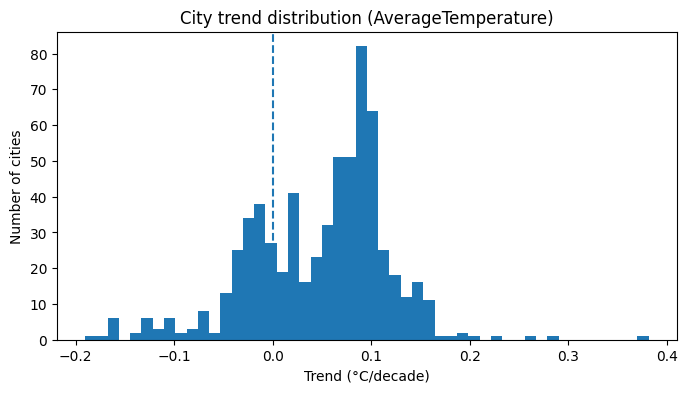

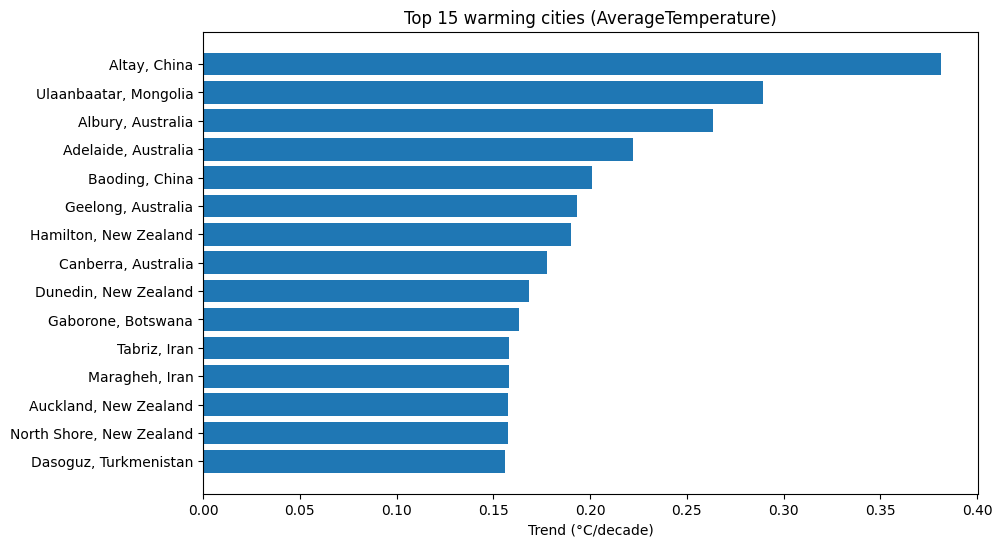

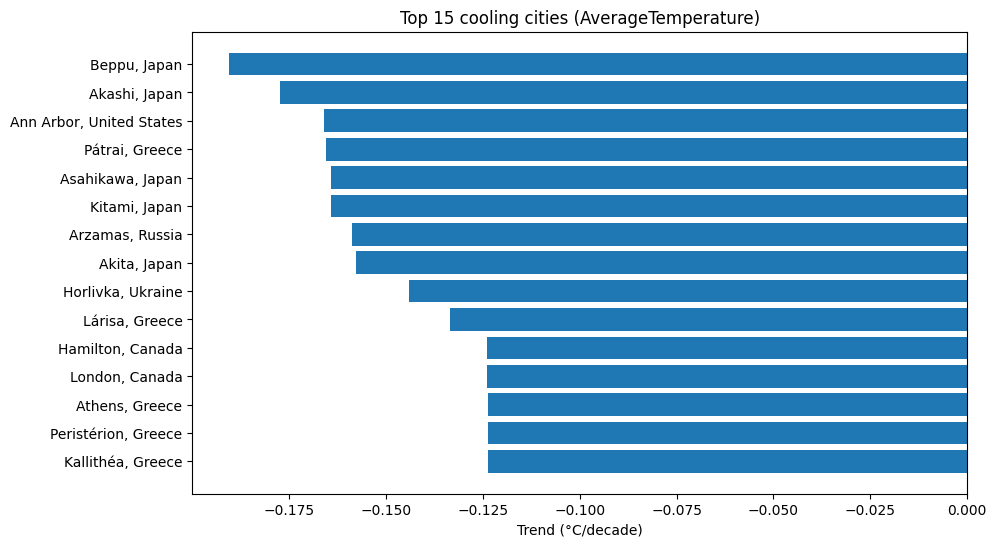

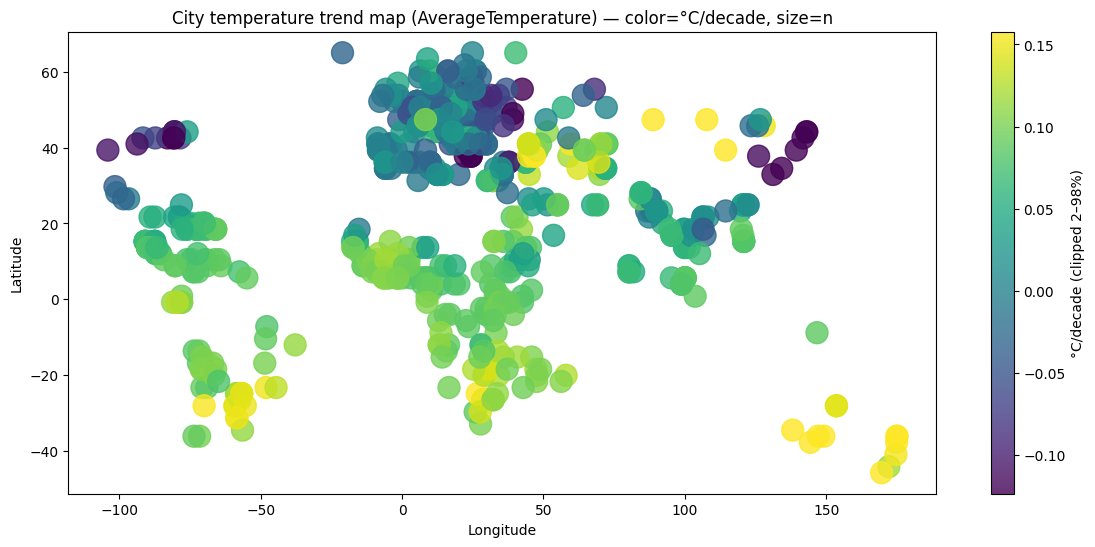

In [ ]:
# ------------------------------------------------------------
# City-level temperature trends (°C/decade), uncertainty-aware
# Uses weighted linear regression: weights = 1 / sigma^2
# You can run this on dl_df (recommended) which has lat/lon + temps.
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= choose what to trend =========
# Option A (recommended): raw temperature
VALUE_COL = 'AverageTemperature'

# Option B: anomaly (if you want anomaly trend)
# VALUE_COL = 'temp_anomaly'

UNC_COL = 'AverageTemperatureUncertainty'   # in °C
MIN_POINTS_CITY = 30                        # minimum observations per city to keep
BASELINE_YEAR0 = 1951                       # just for nicer intercept stability
EPS = 1e-6

if 'dl_df' not in globals():
    raise ValueError("dl_df not found. Run the earlier preprocessing block that creates dl_df first.")

need = ['City','Country','year','lat','lon', VALUE_COL, UNC_COL]
missing = [c for c in need if c not in dl_df.columns]
if missing:
    raise ValueError("Missing columns in dl_df: " + ", ".join(missing))

df_tr = dl_df[need].dropna().copy()
df_tr['year'] = df_tr['year'].astype(int)

# For seasonal data: you may have multiple rows per year (one per season).


# --- Weighted linear regression per group ---
def wls_slope(x, y, sigma):
    """
    Weighted least squares slope & stderr for y ~ a + b*x
    weights = 1/sigma^2
    Returns slope_per_year, slope_se, n
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    sigma = np.asarray(sigma, float)

    # weights
    w = 1.0 / (sigma**2 + EPS)

    # center x to improve numerical stability
    x0 = x - np.average(x, weights=w)

    # slope = sum(w*x0*y)/sum(w*x0^2)
    denom = np.sum(w * x0 * x0)
    if denom <= 0:
        return np.nan, np.nan, len(x)

    b = np.sum(w * x0 * y) / denom

    # residuals and slope standard error (approx)
    y_hat = np.average(y, weights=w) + b * x0
    resid = y - y_hat
    dof = max(len(x) - 2, 1)
    s2 = np.sum(w * resid * resid) / dof
    b_se = np.sqrt(s2 / denom)

    return float(b), float(b_se), int(len(x))

rows = []
for (city, country), g in df_tr.groupby(['City','Country'], sort=False):
    if len(g) < MIN_POINTS_CITY:
        continue

    x = g['year'].to_numpy()
    y = g[VALUE_COL].to_numpy()
    s = g[UNC_COL].to_numpy()

    slope_y, slope_se_y, n = wls_slope(x, y, s)
    if np.isnan(slope_y):
        continue

    # use median coords (stable for that city)
    lat = float(np.median(g['lat'].to_numpy()))
    lon = float(np.median(g['lon'].to_numpy()))

    rows.append({
        'City': city,
        'Country': country,
        'n': n,
        'lat': lat,
        'lon': lon,
        'slope_C_per_year': slope_y,
        'slope_C_per_decade': slope_y * 10.0,
        'slope_se_C_per_decade': slope_se_y * 10.0,
    })

trend_city = pd.DataFrame(rows)
print("Cities kept:", len(trend_city))
display(trend_city.sort_values('slope_C_per_decade', ascending=False).head(10))

# ------------------------------------------------------------
# 1) Distribution plot (how many cities warming vs cooling)
# ------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.hist(trend_city['slope_C_per_decade'].to_numpy(), bins=50)
plt.axvline(0, linestyle='--')
plt.title(f"City trend distribution ({VALUE_COL})")
plt.xlabel("Trend (°C/decade)")
plt.ylabel("Number of cities")
plt.show()

# ------------------------------------------------------------
# 2) Top/bottom cities plot (by magnitude)
# ------------------------------------------------------------
K = 15
top_warm = trend_city.sort_values('slope_C_per_decade', ascending=False).head(K)
top_cool = trend_city.sort_values('slope_C_per_decade', ascending=True).head(K)

plt.figure(figsize=(10,6))
plt.barh(
    (top_warm['City'] + ", " + top_warm['Country']).iloc[::-1],
    top_warm['slope_C_per_decade'].iloc[::-1].to_numpy()
)
plt.title(f"Top {K} warming cities ({VALUE_COL})")
plt.xlabel("Trend (°C/decade)")
plt.ylabel("")
plt.show()

plt.figure(figsize=(10,6))
plt.barh(
    (top_cool['City'] + ", " + top_cool['Country']).iloc[::-1],
    top_cool['slope_C_per_decade'].iloc[::-1].to_numpy()
)
plt.title(f"Top {K} cooling cities ({VALUE_COL})")
plt.xlabel("Trend (°C/decade)")
plt.ylabel("")
plt.show()

# ------------------------------------------------------------
# 3) World map scatter (no basemap required; uses lon/lat scatter)
#    Color = slope, Size = number of points
# ------------------------------------------------------------
# clip extreme values so color scale isn't wrecked by outliers
v = trend_city['slope_C_per_decade'].to_numpy()
v_clip = np.clip(v, np.quantile(v, 0.02), np.quantile(v, 0.98))

plt.figure(figsize=(14,6))
sc = plt.scatter(
    trend_city['lon'], trend_city['lat'],
    c=v_clip,
    s=np.clip(trend_city['n'].to_numpy(), 10, 250),
    alpha=0.8
)
plt.title(f"City temperature trend map ({VALUE_COL}) — color=°C/decade, size=n")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(sc, label="°C/decade (clipped 2–98%)")
plt.show()

# ------------------------------------------------------------
# OPTIONAL: if you want yearly-mean per city before fitting trend
# (reduces seasonal autocorrelation; trend becomes easier to interpret)
# ------------------------------------------------------------
# yearly = (df_tr.groupby(['City','Country','year'], as_index=False)
#           .agg(
#               lat=('lat','median'),
#               lon=('lon','median'),
#               y=(VALUE_COL,'mean'),
#               sigma=(UNC_COL,'mean'),
#               n_seasons=(VALUE_COL,'size')
#           ))
# # then redo the loop using yearly['y'] and yearly['sigma']


This trend section estimates a long run slope for each city using weighted linear regression, where observations with lower reported uncertainty have more influence.

The histogram shows that the distribution of slopes is strongly skewed toward positive values. Most cities cluster around modest warming rates, with the main peak near about 0.07 to 0.12 ?C per decade. There is a smaller tail of negative trends, but it contains fewer cities and the magnitudes are generally smaller than the strongest positive outliers.

The top warming chart highlights a small set of cities with unusually high positive trends. Altay in China stands out at roughly 0.38 ?C per decade, and Ulaanbaatar is also high at roughly 0.29 ?C per decade. Several cities in Australia and New Zealand appear near the top, suggesting strong warming signals in parts of the Southern Hemisphere within this filtered city set.

The top cooling chart is dominated by a cluster of cities in Japan and Greece, with cooling magnitudes around 0.12 to 0.18 ?C per decade. Because these are local extremes, they should be read as city level summaries rather than as a contradiction of global warming, and they are worth checking alongside data coverage to ensure the estimate is well supported.

The longitude and latitude scatter map ties these numbers to geography. Warming appears widespread, while cooler pockets show up more clearly in the Northern Hemisphere, especially around East Asia and parts of Europe. Marker size reflects the number of observations used for each city, so larger points carry more weight in interpretation than isolated small points.


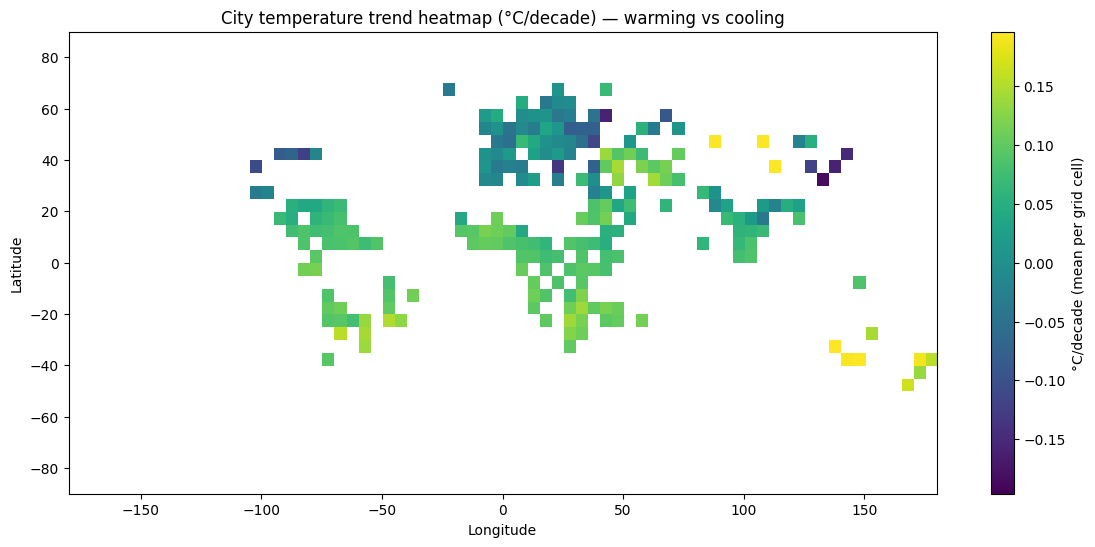

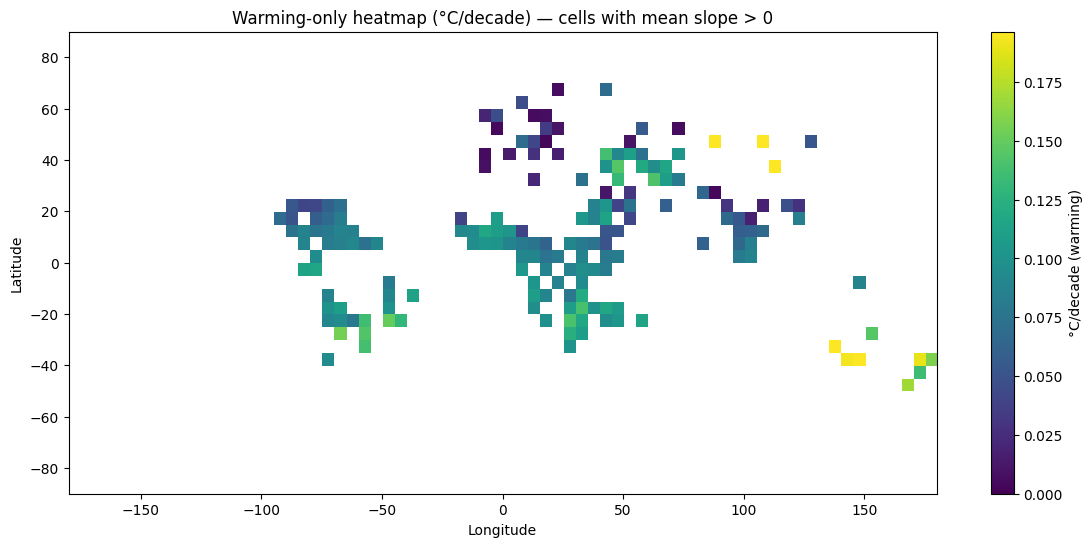

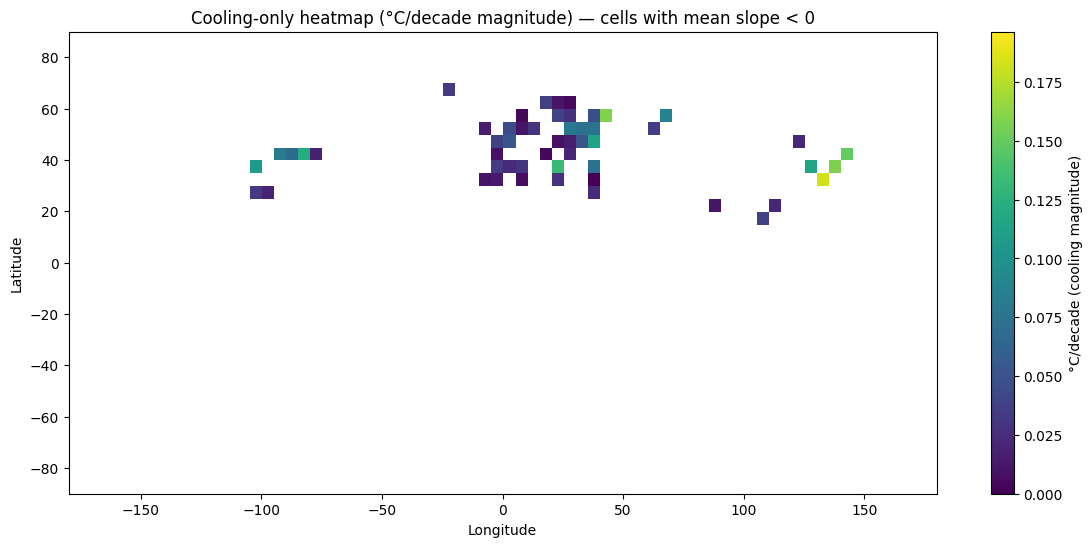

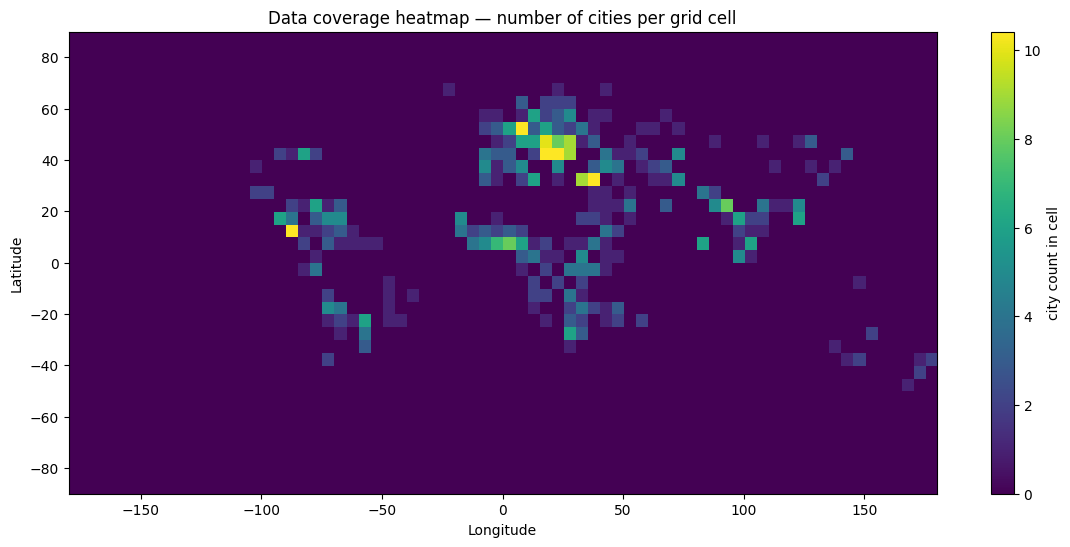

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Heatmap settings
# -----------------------------
if 'trend_city' not in globals():
    raise ValueError("trend_city not found. Run the city-trend block first.")

df = trend_city.dropna(subset=['lat','lon','slope_C_per_decade']).copy()

# Ensure lon is in [-180, 180]
lon = df['lon'].to_numpy().astype(float)
lon = ((lon + 180) % 360) - 180
lat = df['lat'].to_numpy().astype(float)
slope = df['slope_C_per_decade'].to_numpy().astype(float)

# Choose grid resolution (bigger = smoother but less detail)
n_lon_bins = 72   # 5-degree bins (approx)
n_lat_bins = 36   # 5-degree bins (approx)

lon_edges = np.linspace(-180, 180, n_lon_bins + 1)
lat_edges = np.linspace(-90,  90,  n_lat_bins + 1)

# -----------------------------
# Bin cities into grid cells
# Compute mean slope per cell
# -----------------------------
sum_slope, _, _ = np.histogram2d(lat, lon, bins=[lat_edges, lon_edges], weights=slope)
count,     _, _ = np.histogram2d(lat, lon, bins=[lat_edges, lon_edges])

mean_slope = np.divide(sum_slope, count, out=np.full_like(sum_slope, np.nan, dtype=float), where=count>0)

# For separate maps
warming = mean_slope.copy()
warming[warming <= 0] = np.nan

cooling = mean_slope.copy()
cooling[cooling >= 0] = np.nan
cooling = -cooling  # make magnitudes positive for nicer colorbar (optional)

# Set a robust color scale so outliers don't dominate
abs_vals = np.abs(mean_slope[np.isfinite(mean_slope)])
if len(abs_vals) == 0:
    raise ValueError("No valid slope bins. Try lowering MIN_POINTS_CITY or check lat/lon availability.")
vmax = float(np.quantile(abs_vals, 0.98))  # robust max

# Helper: plot a heatmap in lon/lat coordinates
def plot_heat(Z, title, vmin=None, vmax=None, cbar_label=""):
    plt.figure(figsize=(14,6))
    plt.imshow(
        Z,
        origin='lower',
        extent=[lon_edges[0], lon_edges[-1], lat_edges[0], lat_edges[-1]],
        aspect='auto',
        vmin=vmin, vmax=vmax
    )
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label=cbar_label)
    plt.show()

# -----------------------------
# 1) Combined warming/cooling heatmap (diverging)
# -----------------------------
plot_heat(
    mean_slope,
    title="City temperature trend heatmap (°C/decade) — warming vs cooling",
    vmin=-vmax, vmax=+vmax,
    cbar_label="°C/decade (mean per grid cell)"
)

# -----------------------------
# 2) Warming-only heatmap
# -----------------------------
plot_heat(
    warming,
    title="Warming-only heatmap (°C/decade) — cells with mean slope > 0",
    vmin=0, vmax=vmax,
    cbar_label="°C/decade (warming)"
)

# -----------------------------
# 3) Cooling-only heatmap
# (plotted as positive magnitude after flipping sign)
# -----------------------------
plot_heat(
    cooling,
    title="Cooling-only heatmap (°C/decade magnitude) — cells with mean slope < 0",
    vmin=0, vmax=vmax,
    cbar_label="°C/decade (cooling magnitude)"
)

# -----------------------------
# OPTIONAL: data coverage / reliability view
# -----------------------------
plot_heat(
    count,
    title="Data coverage heatmap — number of cities per grid cell",
    vmin=0, vmax=float(np.quantile(count[count>0], 0.98)) if np.any(count>0) else 1.0,
    cbar_label="city count in cell"
)


These heatmaps aggregate the city trend slopes into a coarse latitude and longitude grid and plot the mean trend per cell.

The combined map shows both warming and cooling using a diverging scale, which makes it easy to see where cell averages sit above or below zero. In this run, warming cells are far more common than cooling cells, and the strongest positive values appear in parts of the Southern Hemisphere and in scattered regions across Asia.

The warming only heatmap reinforces that picture by isolating cells with positive mean slope. The cooling only heatmap is much sparser and concentrates mostly in Northern mid latitudes, which aligns with the list of top cooling cities and the scatter map.

The coverage heatmap is crucial context. It shows where each grid cell is supported by many cities and where the estimate is based on only a handful. In this run, coverage is densest across parts of Europe and around several populated belts in Asia and North America. Many cells have little to no coverage, so the safest interpretation is to focus on broad regions with both coherent signal and non trivial coverage.

## Conclusion

Across training and evaluation, the model reaches a validation MAE of 0.5726 ?C and a test MAE of 0.617 ?C. The small train and validation gap at the best checkpoint, together with the modest increase on test, suggests a model that generalises reasonably well while still smoothing out extreme swings in the anomaly series.

The anomaly detection layer behaves as intended under a high quantile threshold. It flags a small number of test windows, and the example city plots show that flagged points correspond to unusually large errors relative to uncertainty.

The trend visualisations provide a complementary long run view. Most cities show positive warming trends, the distribution is centred on modest positive slopes, and the maps show warming as the dominant spatial pattern. Cooling exists but appears in fewer regions and is sensitive to coverage, so it should be interpreted as local variation within an overall warming dominated dataset.
